In [163]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
mp.mp.dps = 30 #higher precision
import csv
import json
from PyMatching import *

In [164]:
#pymatching to compare to
num_shots = 100000
Ls = [4,6,8,10]
ps = np.linspace(0.01, 0.12, 12)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for error_probability in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, error_probability, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=6...
Simulating L=8...
Simulating L=10...


In [165]:
#Log sum exp with arbitrary precision governed by mp
#In particular this gives infinite temperature version of the free energy, for scaling
def log_sum_exp(to_sum):
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return res

#Free energy given histogram and temperature, arbitrary precision governed by mp
def free_energy(E_list, log_g_list,  T):
    to_sum = []
    for i, log_g in enumerate(log_g_list):
        to_sum.append(log_g - E_list[i]/T)
    maxval = max(to_sum)
    exp_sum = 0
    for value in to_sum:
        exp_sum += mp.exp(value-maxval)
    res = maxval + mp.log(exp_sum)
    return -T*res

#Run over batch of results, structured by seed, then by class
def get_free_energies(rescaled_results,temperatures):
    free_energies = []
    for seed_results in rescaled_results:
        free_energy_classes = []
        for error_result in seed_results:
            f_values = []
            for T in temperatures:
                f_values.append(free_energy(error_result[0], error_result[1], T)/(-T))
            free_energy_classes.append(f_values)
        free_energies.append(free_energy_classes)
    return free_energies

#For comparisons to MWPM algorithms
def get_lowest_energies(rescaled_results):
    lowest_energies = []
    for seed_results in rescaled_results:
        lowest_energy_classes = []
        for error_result in seed_results:
            e_values = min(error_result[0])
            lowest_energy_classes.append(e_values)
        lowest_energies.append(lowest_energy_classes)
    return lowest_energies

#For comparisons to MWPM algorithms
def get_lowest_g(rescaled_results):
    lowest_g = []
    for seed_results in rescaled_results:
        lowest_g_classes = []
        for error_result in seed_results:
            g_values = min(error_result[1])
            lowest_g_classes.append(g_values)
        lowest_g.append(lowest_g_classes)
    return lowest_g

In [166]:
#Adapted from https://stackoverflow.com/questions/21708192/how-do-i-use-the-json-module-to-read-in-one-json-object-at-a-time/21709058#21709058

from json import JSONDecoder
from functools import partial

def json_parse(fileobj, decoder=JSONDecoder(), buffersize=20000):

    results = []
    buffer = ''
    for chunk in iter(partial(fileobj.read, buffersize), ''):
        buffer += chunk
        while buffer:
            try:
                result, index = decoder.raw_decode(buffer)
                results.append(result)
                buffer = buffer[index:].lstrip()
            except ValueError:
                # Not enough data to decode, read more
                break


    return results

In [167]:
batch_results = []
probabilities = [0.02,0.06,0.08,0.12]
sizes = [4,6,10]

for p in probabilities:
    print('Probability',p)
    p_res = []
    for size in sizes:
        error_classes = []
        for error in ["I","X","Y","Z"]:
            error_seeds = {}
            filename = "../../../RBIM_results/RBIM/prob_%6f"%p+"/X_%d"%size+"_Y_%d"%size+"/error_class_"+error+"/StitchedHistogram__intervals_10_iterations_1000_overlap_0.250000_walkers_8_alpha_0.800000_beta_0.0001000000exchange_offset50.csv"
            with open(filename, "r") as file:
                results = json_parse(file)
                print(error, len(results))

                for data in results:
                    for seed_key, value in data.items():
                        for key, value in value.items():
                            E_list = []
                            log_g_list = []
                            for key, value in value.items():
                                E_list.append(int(key))
                                log_g_list.append(float(value))
                        #To be removed once normalization is handled in c and works
                        offset = log_sum_exp(log_g_list)

                        ##Below printout shows that there's a discrepancy in rescaling
                        #print('rescaling at size',size,mp.log(2)*size*size - offset)

                        rescaled_log_g_list = [res + mp.log(2)*size*size - offset for res in log_g_list]
                        error_seeds[seed_key] = [E_list, rescaled_log_g_list]

            error_classes.append(error_seeds)

        size_res = []
        for key in error_classes[0].keys():
            if key in error_classes[1].keys() and key in error_classes[2].keys() and key in error_classes[3].keys():
                size_res.append([error_classes[0][key],error_classes[1][key],error_classes[2][key],error_classes[3][key]])
            else:
                print(key,'has issues for at least one class')
        p_res.append(size_res)
        print('size res added for size', size, ":", len(size_res))
    batch_results.append(p_res)

Probability 0.02
I 499
X 500
Y 500
Z 500
size res added for size 4 : 499
I 500
X 500
Y 500
Z 500
size res added for size 6 : 500
I 500
X 500
Y 500
Z 500
size res added for size 10 : 500
Probability 0.06
I 500
X 500
Y 500
Z 500
size res added for size 4 : 500
I 500
X 500
Y 500
Z 500
size res added for size 6 : 500
I 500
X 499
Y 500
Z 500
HistogramSeed_386 has issues for at least one class
size res added for size 10 : 499
Probability 0.08
I 500
X 500
Y 500
Z 500
size res added for size 4 : 500
I 500
X 500
Y 500
Z 500
size res added for size 6 : 500
I 500
X 499
Y 500
Z 500
HistogramSeed_495 has issues for at least one class
size res added for size 10 : 499
Probability 0.12
I 500
X 500
Y 500
Z 500
size res added for size 4 : 500
I 500
X 500
Y 500
Z 500
size res added for size 6 : 500
I 500
X 500
Y 499
Z 500
HistogramSeed_196 has issues for at least one class
size res added for size 10 : 499


In [168]:
### Previous file structure

# batch_results = []

# #probabilities = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12]
# probabilities = [0.01,0.02,0.03,0.04,0.05,0.06]
# sizes = [8]

# for p in probabilities:

#     print('Probability',p)
#     seed_range = range(100,200)

#     p_res = []
#     for size in sizes:

#         print(size)

#         size_res = []
#         for seed in seed_range:
#             seed_res = []
#             all_good = True
#             try:
#                 for error in ["I","X","Y","Z"]:
#                     filename = "../results/periodic/prob_%6f"%p+"/X_%d"%size+"_Y_%d"%size+"/seed_%d"%seed+"/error_class_"+error+"/StitchedHistogram__intervals_40_iterations_1000_overlap_0.250000_walkers_8_seed_run_0_alpha_0.800000_beta_0.0000010000exchange_offset4.csv"
#                     E_list = []
#                     log_g_list = []
#                     with open(filename) as csv_file:
#                         data = csv.reader(csv_file, delimiter=':')
#                         for row in data:
#                             E_list.append(int(row[0]))
#                             log_g_list.append(float(row[1]))

#                     #To be removed once normalization is handled in c
#                     offset = log_sum_exp(log_g_list)
#                     rescaled_log_g_list = [res + mp.log(2)*size*size - offset for res in log_g_list]
#                     seed_res.append([E_list, rescaled_log_g_list])
#             except:
#                 print('One or more error classes had an issue for seed',seed,'at size', size, ', probability',p)
#                 all_good = False

#             if all_good:
#                 size_res.append(seed_res)


#         p_res.append(size_res)
#     batch_results.append(p_res)

In [169]:
free_energies_batch = []
for i, p in enumerate(probabilities):
    print('Probability',p)
    T_Nish = 1/(mp.log((1-p)/p)/2)
    temperatures = [1e-20,T_Nish,1e20]
    free_energies_size = []
    for j in range(len(sizes)):
        print('size',sizes[j])
        free_energies = get_free_energies(batch_results[i][j],temperatures)
        free_energies_size.append(free_energies)
        print('Number of seeds:', len(free_energies))

    free_energies_batch.append(free_energies_size)


Probability 0.02
size 4
Number of seeds: 499
size 6
Number of seeds: 500
size 10
Number of seeds: 500
Probability 0.06
size 4
Number of seeds: 500
size 6
Number of seeds: 500
size 10
Number of seeds: 499
Probability 0.08
size 4
Number of seeds: 500
size 6
Number of seeds: 500
size 10
Number of seeds: 499
Probability 0.12
size 4
Number of seeds: 500
size 6
Number of seeds: 500
size 10
Number of seeds: 499


In [170]:
optimal_curves = []
T0_curves = []
for i, p in enumerate(probabilities):
    optimal_curve = []
    T0_curve = []
    for j in range(len(sizes)):


        free_energies = free_energies_batch[i][j]

        temp = 1 #Nishimori temp
        res =  1 - mp.fsum([f_class[0][temp] <= f_class[1][temp]\
               or f_class[0][temp] <= f_class[2][temp]\
               or f_class[0][temp] <= f_class[3][temp] for f_class in free_energies])/(len(free_energies))
        optimal_curve.append(res)

        temp = 0 #Low temp
        res =  1 - mp.fsum([f_class[0][temp] <= f_class[1][temp]\
               or f_class[0][temp] <= f_class[2][temp]\
               or f_class[0][temp] <= f_class[3][temp] for f_class in free_energies])/(len(free_energies))
        T0_curve.append(res)

    optimal_curves.append(optimal_curve)
    T0_curves.append(T0_curve)

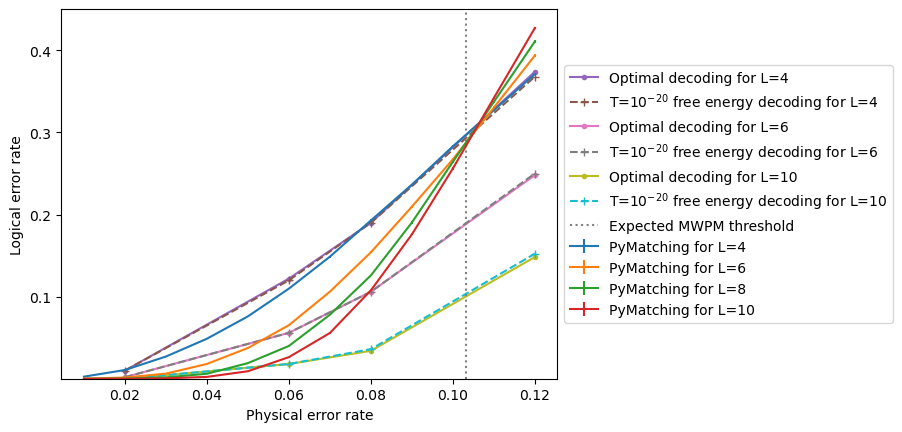

In [171]:
plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="PyMatching for L={}".format(L))


for i, size in enumerate(sizes):
    plt.plot(probabilities, [1-optimal_curves[j][i] for j in range(len(probabilities))],".-",label=r"Optimal decoding for L=%d"%size)
    plt.plot(probabilities, [1-T0_curves[j][i] for j in range(len(probabilities))],"+--",label=r"T=$10^{-20}$ free energy decoding for L=%d"%size)

plt.axvline(x=0.1031,color="gray",label="Expected MWPM threshold",linestyle="dotted")

plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")

#plt.xscale('log')
#plt.yscale('log')
plt.ylim(bottom=1e-4, top=None)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [16]:
import re

def parse_file(filename):
    with open(filename, 'r') as file:
        content = file.read()

    # Split content into individual blocks
    blocks = content.split('}\n{')  # Assuming blocks are separated by double newlines

    print(blocks[1])

    data = []

    for block in blocks:
        # Extract histogram_seed, run_seed, and results
        histogram_seed_match = re.search(r'"histogram_seed": "(\d+)"', block)
        run_seed_match = re.search(r'"run_seed": "(\d+)"', block)
        results_match = re.search(r'"results": \[([^]]*)\]', block)

        if histogram_seed_match and run_seed_match and results_match:
            histogram_seed = histogram_seed_match.group(1)
            run_seed = run_seed_match.group(1)
            results_str = results_match.group(1)

            # Process results
            results = {}
            results_items = results_str.split(',')
            for item in results_items:
                key_value = item.split(':')
                if len(key_value) == 2:
                    key = key_value[0].strip().strip('"')
                    value = float(key_value[1].strip())
                    results[key] = value

            data.append({
                "histogram_seed": histogram_seed,
                "run_seed": run_seed,
                "results": results
            })

    return data

def process_data(data):
    for entry in data:
        histogram_seed = entry["histogram_seed"]
        run_seed = entry["run_seed"]
        results = entry["results"]

        # Initialize lists to store extracted data
        E_list = []
        log_g_list = []

        # Process the results
        for key, value in results.items():
            E_list.append(int(key))
            log_g_list.append(float(value))

        # Example processing
        print('Histogram Seed:', histogram_seed)
        print('Run Seed:', run_seed)
        print('E List:', E_list)
        print('Log G List:', log_g_list)

# Usage
filename = "../results/periodic/prob_0.020000/X_4_Y_4/error_class_I/StitchedHistogram__intervals_10_iterations_1000_overlap_0.250000_walkers_8_alpha_0.800000_beta_0.0001000000exchange_offset50.txt"
data = parse_file(filename)
process_data(data)


  "histogram_seed": "216",
  "run_seed": "1000",
  "results": [
      "-32": 0.687544,
      "-24": 3.44205,
      "-20": 4.13415,
      "-16": 6.06405,
      "-12": 7.44142,
      "-8": 8.82133,
      "-4": 9.51085,
      "0": 9.93556,
      "4": 9.50848,
      "8": 8.80571,
      "12": 7.44813,
      "16": 6.02365,
      "20": 4.14174,
      "24": 3.40909,
      "32": 0.607466
]

Histogram Seed: 119
Run Seed: 1000
E List: [-32, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24, 32]
Log G List: [0.720765, 3.47489, 4.1581, 6.02687, 7.48358, 8.81114, 9.50993, 9.92543, 9.52185, 8.81073, 7.45213, 6.03426, 4.1461, 3.47522, 0.721391]
Histogram Seed: 216
Run Seed: 1000
E List: [-32, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24, 32]
Log G List: [0.687544, 3.44205, 4.13415, 6.06405, 7.44142, 8.82133, 9.51085, 9.93556, 9.50848, 8.80571, 7.44813, 6.02365, 4.14174, 3.40909, 0.607466]
Histogram Seed: 251
Run Seed: 1000
E List: [-32, -24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24, 32